Vamos a comparar la imagen segmentada original con la predicha para localizar los cambios.

Este no es un caso típico de detección de objetos.
El primer paso será vectorizar las imágenes para convertirlas en shapefiles, de esta forma será muy sencillo encontrar los cuadros delimitadores de cada entidad.

Una vez tengamos los cuadros delimitadores los vamos a cruzar para obtener el cuadro delimitador con más IoU.
además, para detectar falsos positivos o construcciones originales que se han dividido o construcciones predichas que agrupan las originales, vamos a calcular la superficie de la construcción detectada en cada cuadro delimitador y si existe construcción en el mismo cuadro pero en la imagen que compara.

Descartaremos todas las construcciones menores de 5 metros por considerar las irrelevantes.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import shapefile
import csv

from PIL import Image
from numpy import asarray


In [2]:
# Imagenes que vamos a comparar
# original
IMAGE_ORI = '689795.95_4197188.34_690051.95_4197444.34.png'
# imagen predicha
IMAGE_PRE = 'foto2.png' 
#resolucion
RESOLUCION = 0.25

In [3]:
# Creamos un shapefile temporal 
%run gdal_polygonize.py 689795.95_4197188.34_690051.95_4197444.34.png -f "ESRI Shapefile" temp/original.shp
%run gdal_polygonize.py foto2.png -f "ESRI Shapefile" temp/prediccion1.shp

In [4]:
# Creamos arrays con los datos de las imagenes
imagen_original = Image.open(IMAGE_ORI)
data_original = asarray(imagen_original)
#imagen predicha
imagen_predicha = Image.open(IMAGE_PRE)
data_predicha = asarray(imagen_predicha)

In [5]:
#Calcula el IOU de 2 BBOX

def bb_intersection_over_union(boxA, boxB):
# determina coordenadas (x, y)-del rectangulo de interseccion
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # calcula el area del rectangulo
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # calcula el área de la predicción y la rectangulo de la zona correcta
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # Calcula el IOu tomando la interseccion
    # y dividienddola por la suma prediccion menos la real menos la interseccion
    # area and dividing it by the sum of prediction + ground-truth
    iou = round(interArea / float(boxAArea + boxBArea - interArea),2)
    # devuelve iou
    return iou

In [6]:
def obtener_bbox(shp):
    #array donde guardaremos las coordendas del bbox
    bbox=[]
    #leemos el shapefile
    sf  = shapefile.Reader(shp)
    #obtenemos los poligonos del shapefile
    shapes = sf.shapes()
    #Obtenemos el bbox para cada poligono
    for n in range(0, len(shapes)):
        #cuadro obtiene los xmin,ymin,xmax,ymax de la caja delimitadora
        cuadro = shapes[n].bbox
        #lo convertimos en entero
        cuadro = [int(round(float(i))) for i in cuadro]
        #lo añadimos al array
        bbox.append(cuadro)
    return (bbox)

In [7]:
def iou_maximo(boxA,boxB):
    #Array para guardar iou y posicion box de cruce 
    #array que guarda los valores iou
    iou = []
    #array que guarda las posiciones del bbox con los que cruza
    posicion = []
    #Recorremos todass las cajas
    for i in range (0, len(boxA)):
        iou_temp = []
        for j in range (0, len(boxB)):
            #calculamos iou entre cajas
            iou_temp.append(bb_intersection_over_union(boxA[i], boxB[j]))
        #Si el valor es 0, no hay cruce , la  posicion -1
        #Si cruza, decuelve el valor iou y posicion de cruce
        if (max(iou_temp) == 0):
            posicion.append(-1)
            iou.append(0)
        else:
            #si hay cruce guardamos el valor mas alto
            posicion.append(iou_temp.index(max(iou_temp)))
            #y la pososicion
            iou.append(max(iou_temp))
    #devuelve vectores iou maximas y posicion box cruce
    return (iou, posicion)
            

In [8]:
def caracteristicas(boxA):
    ancho = [] 
    alto = []
     #Recorremos todas las cajas
    for i in range (0, len(boxA)):
        #restamos las posiciones x
        ancho.append(boxA[i][2] - boxA[i][0])
        #restamos lass posiciones y
        alto.append(boxA[i][3] - boxA[i][1])
    #devuelve el alto y ancho de la caja
    return(alto,ancho)

In [9]:
def acc(boxA):
    acc = []
    for i in range (0, len(boxA)):
        c = 0
        #recortamos la imagen original con las dimensiones de la caja
        recorte_original = data_original[boxA[i][1] : boxA[i][3], boxA[i][0] : boxA[i][2]]
        #recortamps la imagen predicha con las dimensiones de la caja
        recorte_predicho = data_predicha[boxA[i][1] : boxA[i][3], boxA[i][0] : boxA[i][2]]
        #recorremos los pixeles
        for i in range (0, recorte_original.shape[0]):
            for j in range (0, recorte_original.shape[1]):
                #si son igales: acierto
                if (recorte_original[i][j] == recorte_predicho[i][j]):
                    c = c + 1
        area=recorte_original.shape[0] * recorte_original.shape[1]
        acc.append((c / area) * 100) 
    #devuelve el accuracy entre las cajas   
    return(acc)

In [10]:
def superficie(datos,boxA):
    #contamos los pixeles con valor 255
    blancos = []
    for i in range (0, len(boxA)):
        recorte = datos[boxA[i][1] : boxA[i][3], boxA[i][0] : boxA[i][2]]
        #obtenemos la superficie multiplicando por las dimensiones del pixel 
        blancos.append(np.count_nonzero(recorte) * (0.25 * 0.25)) 
    return(blancos)

In [11]:
def color_pixel(datos,x,y):
    return(datos[x:y:0])

In [12]:
def crear_imagen(imagen,box,lista,col):
    #creamos una imagen añadiento los cuadros con las incidencias
    im = cv2.imread(imagen)
    #recorremos el array con las incidencias detectadas
    for i in range(0, len(lista)):
        #obtenemos lass dimensiones del cuadro
        topleft_x, topleft_y, bottom_right_x, bottom_right_y = box[lista[i]]
        #dibujamos el cuadro con el color que se nos indica
        cv2.rectangle(im, (topleft_x, topleft_y), (bottom_right_x, bottom_right_y), color = col, thickness = 2)    
    #decolvemos la imagen
    return(im)

In [13]:
'''
Creamos un¡ dataframe para cada una de las imagenes con las sigueintes columnas:
BBOX: Coordendas del cuadro delimitador
Ancho: Ancho del cuadro
ALto: Alto del cuadro
IoU: Valor IoU mas alto del cuadro
BOX_CRUCE: Caja de la otra imagen con la que se obtiene el IoU mass alto
ACC: Pixeles bien predichos
SUPERFICIE: SUperficie de la construccion que engloba la caja
SUP_INV: Superficie de la construccion de la caja pero en la imagen con la que compara
'''
df_original = pd.DataFrame(columns = ('BBOX', 'ANCHO', 'ALTO', 'IOU', 'BOX_CRUCE', 'ACC', 'SUPERFICIE','SUP_INV'))
df_predicho = pd.DataFrame(columns = ('BBOX', 'ANCHO', 'ALTO', 'IOU', 'BOX_CRUCE', 'ACC', 'SUPERFICIE','SUP_INV'))

In [14]:
df_original['BBOX'] = bbox_original = obtener_bbox("temp/original.shp")
df_predicho['BBOX'] = bbox_predicho = obtener_bbox("temp/prediccion1.shp")


In [15]:
df_original['IOU'], df_original['BOX_CRUCE'] = iou_maximo(bbox_original, bbox_predicho)
df_predicho['IOU'], df_predicho['BOX_CRUCE'] = iou_maximo(bbox_predicho, bbox_original)

In [16]:
df_original['ALTO'], df_original['ANCHO'] = caracteristicas(bbox_original)
df_predicho['ALTO'], df_predicho['ANCHO'] = caracteristicas(bbox_predicho)

In [17]:
df_original['SUPERFICIE'] = superficie(data_original, bbox_original)
df_predicho['SUPERFICIE'] = superficie(data_predicha, bbox_predicho)
df_original['SUP_INV'] = superficie(data_predicha, bbox_original)
df_predicho['SUP_INV'] = superficie(data_original, bbox_predicho)

In [18]:
df_original['ACC'] = acc(bbox_original)
df_predicho['ACC'] = acc(bbox_predicho)

In [19]:
df_original.head()


,BBOX,ANCHO,ALTO,IOU,BOX_CRUCE,ACC,SUPERFICIE,SUP_INV
0,"[244, 0, 265, 8]",21,8,0.00,-1,42.857143,6.0000,0.0000
1,"[114, 0, 161, 24]",47,24,0.87,3,83.333333,50.5000,55.2500
2,"[108, 15, 147, 45]",39,30,0.84,4,72.051282,46.8750,44.3125
3,"[0, 9, 50, 55]",50,46,0.52,5,37.695652,87.8125,61.3750
4,"[188, 7, 257, 71]",69,64,0.82,6,85.937500,140.6250,149.5625


In [20]:
df_predicho.head()

,BBOX,ANCHO,ALTO,IOU,BOX_CRUCE,ACC,SUPERFICIE,SUP_INV
0,"[476, 0, 493, 2]",17,2,0.00,-1,14.705882,1.8125,0.0
1,"[495, 0, 496, 1]",1,1,0.00,-1,0.000000,0.0625,0.0
2,"[284, 0, 314, 20]",30,20,0.00,-1,36.000000,24.0000,0.0
3,"[115, 0, 159, 26]",44,26,0.87,1,82.167832,57.8750,52.5
4,"[108, 17, 143, 45]",35,28,0.84,2,72.653061,40.0000,42.0


# Mostramos resultados 

Text(0.5, 1.0, 'Predicha bbox')

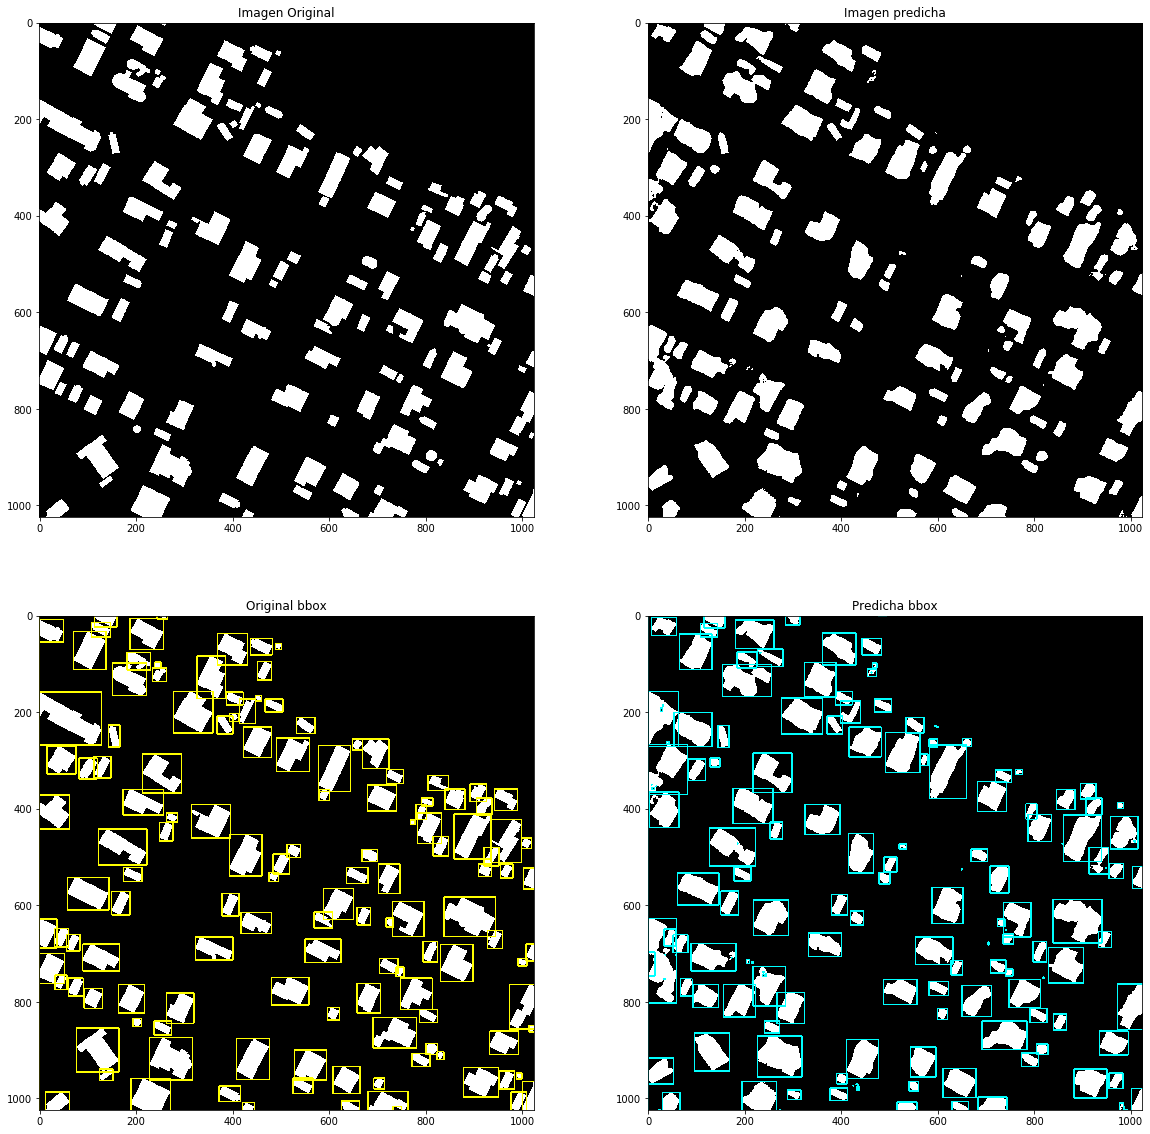

In [21]:
im_ori = image_ori_bbox = cv2.imread(IMAGE_ORI) 
im_pre = image_pre_bbox = cv2.imread(IMAGE_PRE)

#Creamos la imagen original mostrando sus BBOX
imagen_original_bbox = crear_imagen(IMAGE_ORI, bbox_original, df_original.index, (255, 255, 0))
#creamos la imagen predicha mostrando sus BBOX
imagen_predicha_bbox = crear_imagen(IMAGE_PRE, bbox_predicho, df_predicho.index, (0, 255, 255))

plt.figure(figsize = (20, 20))

plt.subplot(221)
plt.imshow(im_ori)
plt.title('Imagen Original')

plt.subplot(222)
plt.imshow(im_pre)
plt.title('Imagen predicha')

plt.subplot(223)
plt.imshow(imagen_original_bbox)
plt.title('Original bbox')

plt.subplot(224)
plt.imshow(imagen_predicha_bbox)
plt.title('Predicha bbox')

# IOU superior a 0.5

Text(0.5, 1.0, 'Imagen predicha IOU>0.5')

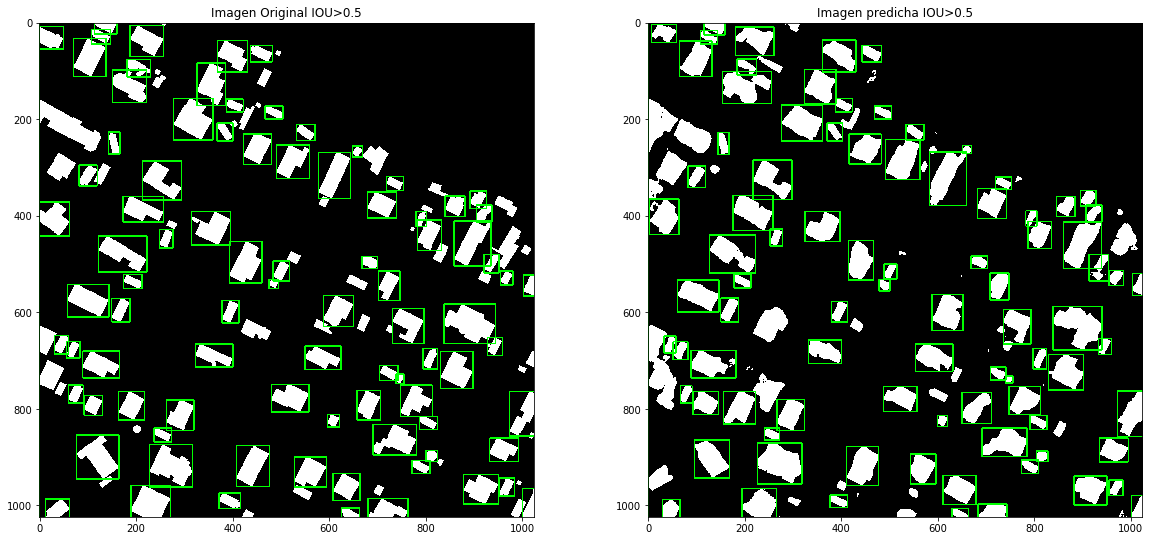

In [22]:
#A partir de Iou>0.5 considreamos que la deteccion ha sido correcta

df_ori_iou = df_original.index[(df_original['IOU'] >= 0.5)]
df_pre_iou = df_predicho.index[(df_predicho['IOU'] >= 0.5)]

#imagen original con los bbox>0.5 que consideramos correcto
imagen_original_iou = crear_imagen(IMAGE_ORI, bbox_original, df_ori_iou, (0, 255, 0))
#imagen predicha con los bbox>0.5 que consideramos correcto
imagen_predicha_iou = crear_imagen(IMAGE_PRE, bbox_predicho, df_pre_iou, (0, 255, 0))

plt.figure(figsize = (20, 20))

plt.subplot(221)
plt.imshow(imagen_original_iou)
plt.title('Imagen Original IOU>0.5')

plt.subplot(222)
plt.imshow(imagen_predicha_iou)
plt.title('Imagen predicha IOU>0.5')


# Construcciones de mas de 5m2 que no cruzan

Text(0.5, 1.0, 'Imagen predicha nuevas construcciones')

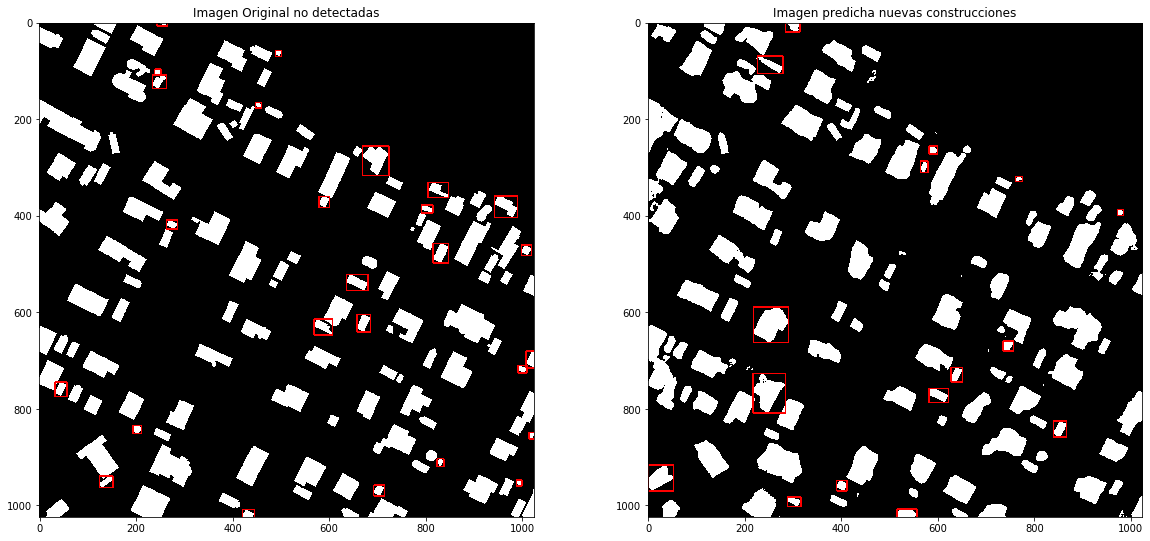

In [23]:
#Si tenemos superficies de mas de 5m2 con Iou inferior a 0.1 
#o que no tienen superficie si pasamos la caja a la imagen comprada, consideramos que hay incidencia

#en la imagen original, no detectados. Obtenemos los indices del df
original_nocruza = df_original.index[((df_original['SUP_INV'] == 0) | (df_original['IOU'] <= 0.1))
                                     & (df_original['SUPERFICIE'] > 5) ]
#en la imagen predicha, nuevass construcciones. Obtenemos los indices del df
predicho_nocruza = df_predicho.index[((df_predicho['SUP_INV'] == 0) | (df_predicho['IOU'] <= 0.1)) 
                                     & (df_predicho['SUPERFICIE'] > 5) ]

imagen_original_no = crear_imagen(IMAGE_ORI, bbox_original, original_nocruza, (255, 0, 0))
imagen_predicha_no = crear_imagen(IMAGE_PRE, bbox_predicho, predicho_nocruza, (255, 0, 0))

plt.figure(figsize = (20, 20))

plt.subplot(221)
plt.imshow(imagen_original_no)
plt.title('Imagen Original no detectadas')

plt.subplot(222)
plt.imshow(imagen_predicha_no)
plt.title('Imagen predicha nuevas construcciones')


# Ampliaciones

In [24]:
#creamos un dataframe eliminado las anteriores incidencias
resto_box = df_predicho.drop(df_pre_iou)
resto_box = resto_box.drop(predicho_nocruza)

Text(0.5, 1.0, 'Imagen predicha')

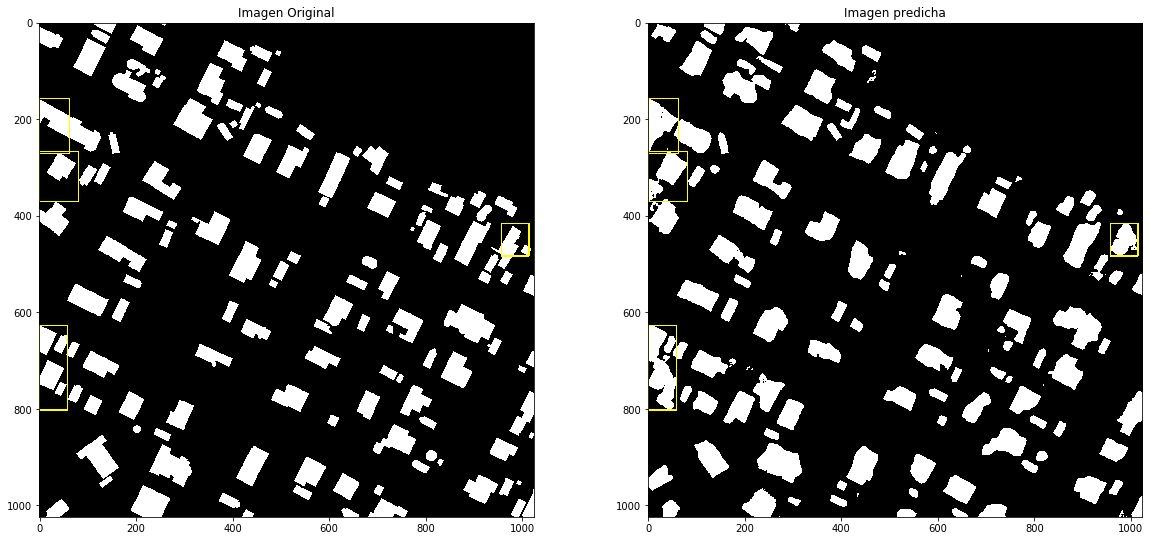

In [25]:
#Consideramos ampliacion, si la superficie predicha es un 25% superior a la original y mayor de 5m2

df_ampliacion = resto_box.index[((resto_box['SUP_INV'] * 1.25) < resto_box['SUPERFICIE']) & (resto_box['SUPERFICIE'] > 5)]

#Mostramos las ampliaciones,con los mismos cuadros delimitadores en lass 2 imagenes paar observar la incidencia
imagen_original_ampliacion = crear_imagen(IMAGE_ORI, bbox_predicho, df_ampliacion, (255, 255, 0))
imagen_predicha_ampliacion = crear_imagen(IMAGE_PRE, bbox_predicho, df_ampliacion, (255, 255, 0))

plt.figure(figsize = (20, 20))

plt.subplot(221)
plt.imshow(imagen_original_ampliacion)
plt.title('Imagen Original')

plt.subplot(222)
plt.imshow(imagen_predicha_ampliacion)
plt.title('Imagen predicha')



# Creacion csv con datos de salida

In [26]:
'''Estos son lass incidencias detectadas.
Vamos a crear iun csv con el tipo de incidenciay sus coordenadass para que se pueda gargar en Qgis'''

ampliaciones = df_ampliacion
nueva_construccion = predicho_nocruza
no_localizados = original_nocruza

In [27]:
#dividimos el nombre de la imagen original para obtener als corrdendas
xmin, ymin, xmax, ymax = IMAGE_ORI.split('_') 
#float(ymax[:-4])
coord = []
#cabecera del CSV
coord.append(['X','Y','ESTADO'])

#calculamos lass cooordendas para las ampliaciones
for xx in range (0, len(df_ampliacion)):
    t = (bbox_predicho[df_ampliacion[xx]])
    x = float(xmin) + (t[0] + ((t[2] - t[0]) / 2)) * RESOLUCION
    y = float(ymax[:-4]) - (t[1] + ((t[3] - t[1]) / 2)) * RESOLUCION
    coord.append([x, y, 'AMPLIACION'])
    
#calculamos lass cooordendas para las nuevass construcciones    
for xx in range (0, len(predicho_nocruza)):
    t = (bbox_predicho[predicho_nocruza[xx]])
    x = float(xmin) + (t[0] + ((t[2] - t[0]) / 2)) * RESOLUCION
    y = float(ymax[:-4]) - (t[1] + ((t[3]-t[1]) / 2)) * RESOLUCION
    coord.append([x, y, 'NUEVA CONSTRUCCION'])

    #calculamos lass cooordendas para las no dectadas  
for xx in range (0, len(original_nocruza)):
    t = (bbox_original[original_nocruza[xx]])
    x = float(xmin) + (t[0] + ((t[2] - t[0]) / 2)) * RESOLUCION
    y = float(ymax[:-4]) - (t[1] + ((t[3]-t[1]) / 2)) * RESOLUCION
    coord.append([x, y, 'NO DETECTADAS'])
   

In [28]:
#creamos el ficheros coordendas_incidencia con el array coord
with open('coordendas_incidencia.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(coord)

Este csv lo podemos cargar en QGIS como capa de texto delimitado

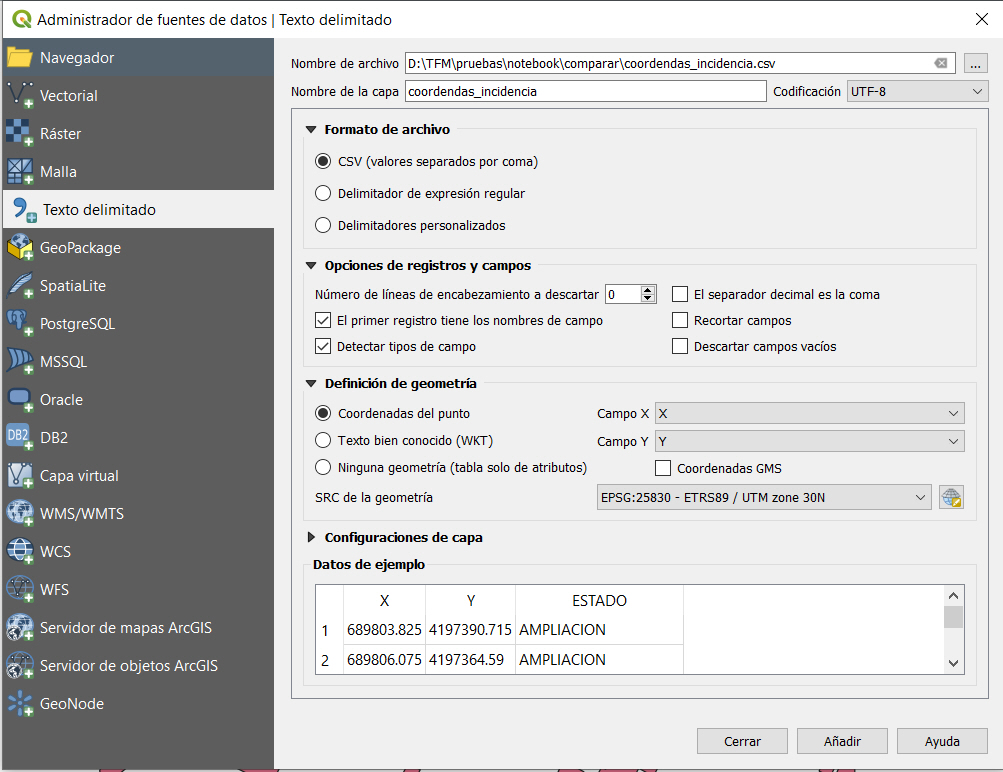

Y posteriomente visualizar la capa con las incidencias categorizadas

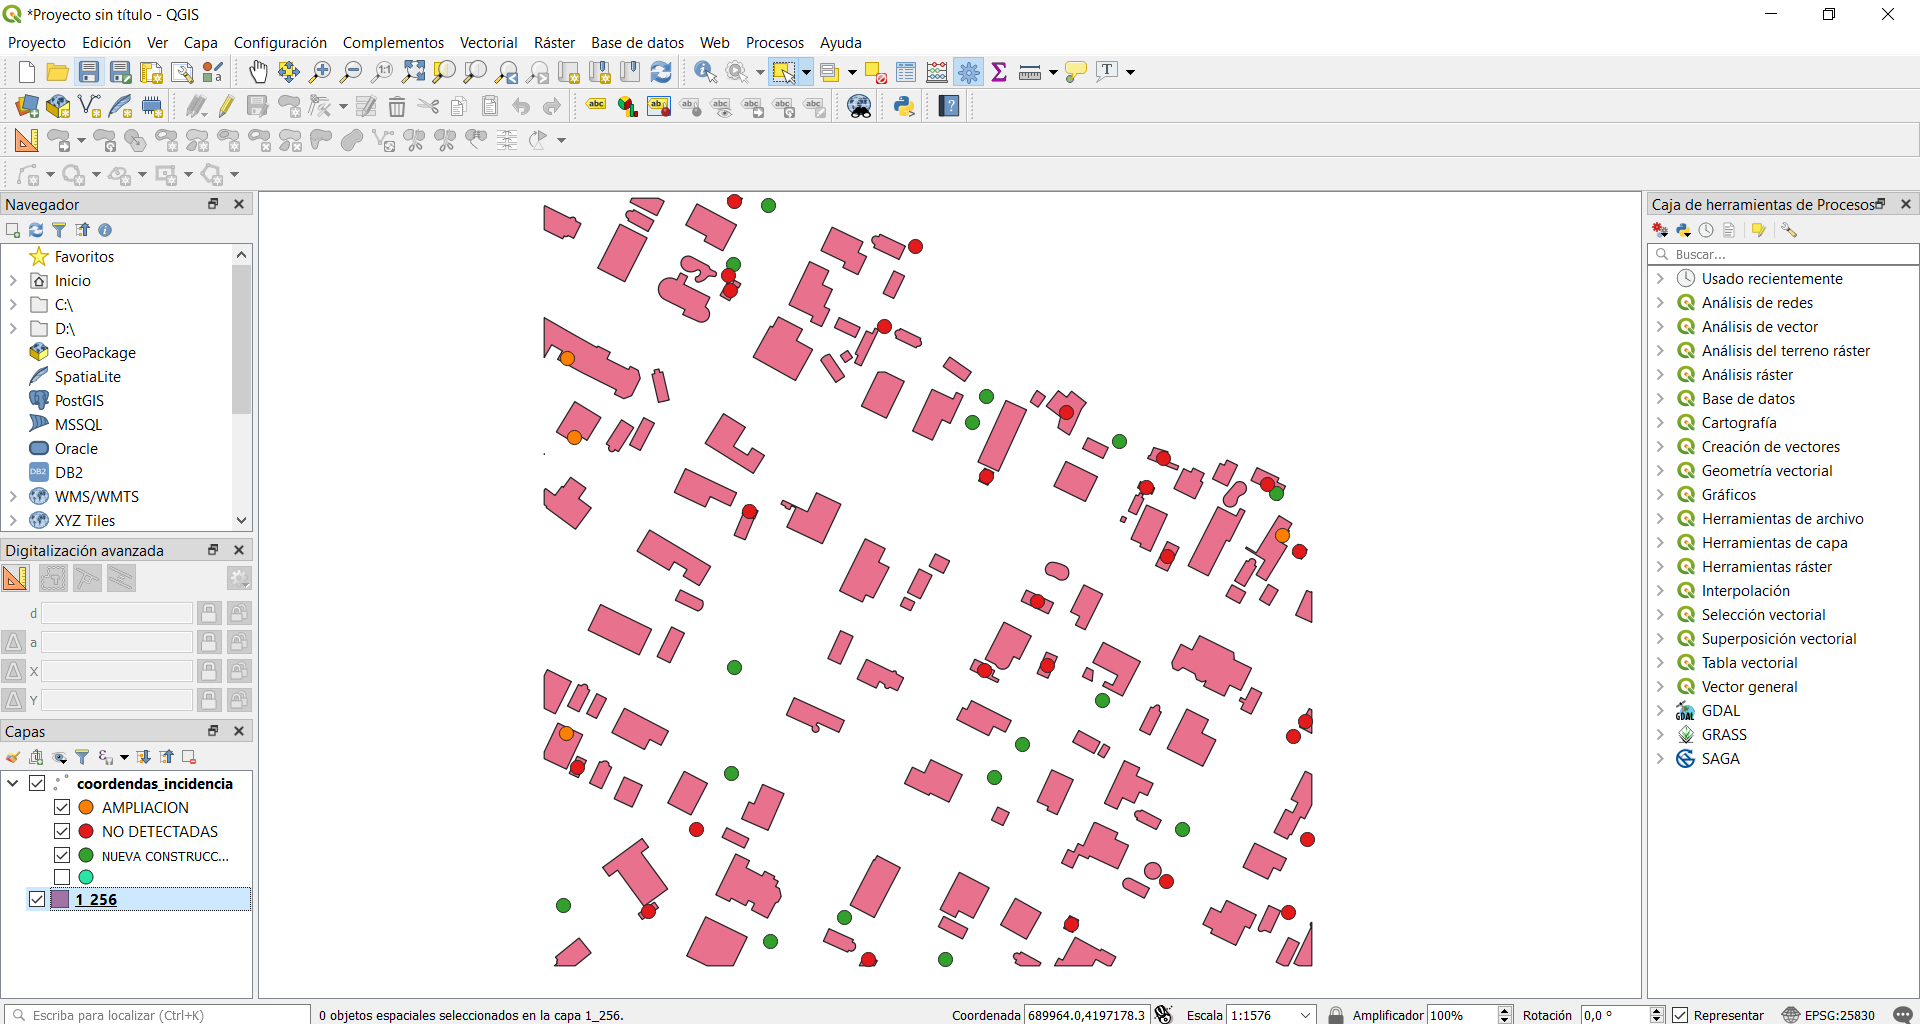